# Análises Complexas - Dados Bancários

Este notebook contém **3 consultas complexas** utilizando JOINs e Window Functions para análise avançada dos dados bancários.

## Objetivo
- Análises temporais sofisticadas
- Ranking e comparações entre períodos
- Detecção de padrões e tendências
- Análises de cohort e performance relativa

In [1]:
# Configuração inicial
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sqlalchemy import create_engine, text
from datetime import datetime, timedelta
import numpy as np
import warnings, os
from dotenv import load_dotenv 
 
# Carregar variáveis do arquivo .env de um diretório específico
env_path = "../env_files/.env"
load_dotenv(dotenv_path=env_path)
warnings.filterwarnings('ignore')

# Database configuration
DB_CONFIG = {
    'host': os.getenv("PGHOST", "localhost"),
    'port': os.getenv("PGPORT", "5432"),
    'user': os.getenv("PGUSER", "postgres"),
    'password': os.getenv("PGPASSWORD", "postgres"),
    'database': os.getenv("PGDATABASE", "postgres")  # Default database to connect initially
}

# Criar conexão
connection_string = f"postgresql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['database']}"
engine = create_engine(connection_string)

# Schema alvo
TARGET_SCHEMA = "mkl_bank"

# Configurar estilo dos gráficos
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

print("🚀 Configuração para análises complexas concluída!")
print(f"🔗 Conectado ao banco: {DB_CONFIG['database']}")
print(f"📊 Schema: {TARGET_SCHEMA}")
print(f"⚡ Pronto para análises avançadas com Window Functions!")

🚀 Configuração para análises complexas concluída!
🔗 Conectado ao banco: fsi_db
📊 Schema: mkl_bank
⚡ Pronto para análises avançadas com Window Functions!


## 📈 Consulta 1: Análise Temporal de Performance com Ranking

**Objetivo**: Analisar a evolução temporal das agências usando window functions para ranking, crescimento e análise de trends.

In [4]:
# Primeiro, vamos verificar a conectividade com uma consulta simples
try:
    teste_conexao = pd.read_sql(text(f"SELECT COUNT(*) as total FROM {TARGET_SCHEMA}.agencia LIMIT 1"), engine)
    print(f"✅ Conexão OK - Total de agências: {teste_conexao['total'].iloc[0]}")
except Exception as e:
    print(f"❌ Erro de conexão: {e}")
    raise

# Consulta 1: Análise temporal de performance com ranking
query_1_text = f"""
WITH movimentacao_mensal AS (
    SELECT 
        a.codigo_agencia,
        a.nome as nome_agencia,
        a.cidade,
        a.estado,
        DATE_TRUNC('month', t.data_transacao) as mes_ano,
        COUNT(t.id_transacao) as total_transacoes,
        SUM(t.valor) as valor_total,
        AVG(t.valor) as valor_medio
    FROM {TARGET_SCHEMA}.agencia a
    JOIN {TARGET_SCHEMA}.conta c ON a.codigo_agencia = c.codigo_agencia
    JOIN {TARGET_SCHEMA}.transacao_conta t ON c.id_conta = t.id_conta
    WHERE t.data_transacao >= '2024-01-01'
    GROUP BY a.codigo_agencia, a.nome, a.cidade, a.estado, 
             DATE_TRUNC('month', t.data_transacao)
),
ranking_performance AS (
    SELECT *,
        -- Rankings mensais
        RANK() OVER (PARTITION BY mes_ano ORDER BY valor_total DESC) as ranking_valor_mes,
        RANK() OVER (PARTITION BY mes_ano ORDER BY total_transacoes DESC) as ranking_transacoes_mes,
        
        -- Análise temporal com LAG
        LAG(valor_total, 1) OVER (PARTITION BY codigo_agencia ORDER BY mes_ano) as valor_mes_anterior,
        LAG(total_transacoes, 1) OVER (PARTITION BY codigo_agencia ORDER BY mes_ano) as transacoes_mes_anterior,
        
        -- Médias móveis (3 meses)
        AVG(valor_total) OVER (
            PARTITION BY codigo_agencia 
            ORDER BY mes_ano 
            ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
        ) as media_movel_3m_valor,
        
        AVG(total_transacoes) OVER (
            PARTITION BY codigo_agencia 
            ORDER BY mes_ano 
            ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
        ) as media_movel_3m_transacoes,
        
        -- Percentil por estado
        PERCENT_RANK() OVER (PARTITION BY estado, mes_ano ORDER BY valor_total) as percentil_estado
        
    FROM movimentacao_mensal
),
crescimento_calculado AS (
    SELECT *,
        CASE 
            WHEN valor_mes_anterior > 0 THEN 
                ((valor_total - valor_mes_anterior) / valor_mes_anterior::float) * 100
            ELSE NULL 
        END as crescimento_valor_pct,
        
        CASE 
            WHEN transacoes_mes_anterior > 0 THEN 
                ((total_transacoes - transacoes_mes_anterior) / transacoes_mes_anterior::float) * 100
            ELSE NULL 
        END as crescimento_transacoes_pct
        
    FROM ranking_performance
)
SELECT 
    codigo_agencia,
    nome_agencia,
    cidade,
    estado,
    mes_ano,
    total_transacoes,
    valor_total,
    ranking_valor_mes,
    ranking_transacoes_mes,
    crescimento_valor_pct,
    crescimento_transacoes_pct,
    media_movel_3m_valor,
    percentil_estado,
    CASE 
        WHEN percentil_estado >= 0.8 THEN 'Top 20%'
        WHEN percentil_estado >= 0.6 THEN 'Acima da Média'
        WHEN percentil_estado >= 0.4 THEN 'Média'
        WHEN percentil_estado >= 0.2 THEN 'Abaixo da Média'
        ELSE 'Bottom 20%'
    END as classificacao_estado
FROM crescimento_calculado
WHERE mes_ano >= '2024-01-01'
ORDER BY mes_ano DESC, ranking_valor_mes
LIMIT 50;
"""

try:
    resultado_1 = pd.read_sql(text(query_1_text), engine)
    
    print("📈 ANÁLISE TEMPORAL DE PERFORMANCE COM RANKING")
    print("=" * 100)
    print(f"{'Agência':<8} {'Cidade':<12} {'Mês':<8} {'Rank Val':<8} {'Crescimento':<11} {'Classificação':<15}")
    print("-" * 100)

    for _, row in resultado_1.head(15).iterrows():
        mes_str = row['mes_ano'].strftime('%Y-%m') if pd.notna(row['mes_ano']) else 'N/A'
        crescimento = f"{row['crescimento_valor_pct']:.1f}%" if pd.notna(row['crescimento_valor_pct']) else 'N/A'
        
        print(f"{row['codigo_agencia']:<8} {row['cidade'][:11]:<12} {mes_str:<8} "
              f"{row['ranking_valor_mes']:>6} {crescimento:>10} {row['classificacao_estado']:<15}")

    # Visualizações avançadas
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Evolução do Ranking das Top 5 Agências',
            'Distribuição de Crescimento Mensal',
            'Correlação: Transações vs Valor',
            'Performance por Estado (Percentil)'
        ),
        specs=[[{"type": "scatter"}, {"type": "histogram"}],
               [{"type": "scatter"}, {"type": "bar"}]]
    )

    # Gráfico 1: Evolução do ranking
    if len(resultado_1) > 0:
        top_agencias = resultado_1.groupby('codigo_agencia')['valor_total'].sum().nlargest(5).index
        cores = ['red', 'blue', 'green', 'orange', 'purple']

        for i, agencia in enumerate(top_agencias):
            dados_agencia = resultado_1[resultado_1['codigo_agencia'] == agencia].sort_values('mes_ano')
            fig.add_trace(
                go.Scatter(
                    x=dados_agencia['mes_ano'],
                    y=dados_agencia['ranking_valor_mes'],
                    mode='lines+markers',
                    name=f'Agência {agencia}',
                    line=dict(color=cores[i]),
                    yaxis='y'
                ),
                row=1, col=1
            )

        # Gráfico 2: Distribuição de crescimento
        crescimentos_validos = resultado_1['crescimento_valor_pct'].dropna()
        if len(crescimentos_validos) > 0:
            fig.add_trace(
                go.Histogram(
                    x=crescimentos_validos,
                    nbinsx=20,
                    name='Crescimento %',
                    marker_color='lightblue',
                    opacity=0.7
                ),
                row=1, col=2
            )

        # Gráfico 3: Correlação
        fig.add_trace(
            go.Scatter(
                x=resultado_1['total_transacoes'],
                y=resultado_1['valor_total'],
                mode='markers',
                text=resultado_1['codigo_agencia'],
                name='Agências',
                marker=dict(
                    size=8,
                    color=resultado_1['percentil_estado'],
                    colorscale='Viridis',
                    colorbar=dict(title="Percentil Estado"),
                    opacity=0.7
                )
            ),
            row=2, col=1
        )

        # Gráfico 4: Performance por estado
        perf_estado = resultado_1.groupby('estado')['percentil_estado'].mean().sort_values(ascending=False).head(10)
        fig.add_trace(
            go.Bar(
                x=perf_estado.index,
                y=perf_estado.values,
                name='Percentil Médio',
                marker_color='gold',
                opacity=0.8
            ),
            row=2, col=2
        )

        # Inverter eixo Y do ranking (1 = melhor)
        fig.update_yaxes(autorange="reversed", row=1, col=1)

        fig.update_layout(height=800, showlegend=True, title_text="Análise Temporal Avançada com Window Functions")
        fig.show()

        # Estatísticas de resumo
        print(f"\n📊 Insights Avançados:")
        if len(resultado_1[resultado_1['ranking_valor_mes'] == 1]) > 0:
            melhor_agencia = resultado_1.loc[resultado_1['ranking_valor_mes'] == 1].iloc[0]
            print(f"• Líder atual: Agência {melhor_agencia['codigo_agencia']} ({melhor_agencia['cidade']})")
        
        if len(crescimentos_validos) > 0:
            print(f"• Crescimento médio: {crescimentos_validos.mean():.2f}%")
            print(f"• Volatilidade (std): {crescimentos_validos.std():.2f}%")
        
        print(f"• Estados top performance: {', '.join(perf_estado.head(3).index)}")
        print(f"• Total de registros analisados: {len(resultado_1)}")
    else:
        print("⚠️ Nenhum resultado encontrado na consulta")

except Exception as e:
    print(f"❌ Erro na execução da consulta: {e}")
    import traceback
    traceback.print_exc()

✅ Conexão OK - Total de agências: 166
📈 ANÁLISE TEMPORAL DE PERFORMANCE COM RANKING
Agência  Cidade       Mês      Rank Val Crescimento Classificação  
----------------------------------------------------------------------------------------------------
4522     Rocha        2024-05       1     -49.8% Top 20%        
2199     Vieira       2024-05       2     -46.0% Top 20%        
4123     Albuquerque  2024-05       3     -23.8% Top 20%        
5981     Rocha Pauli  2024-05       4     -53.6% Acima da Média 
8316     Pinto        2024-05       5     -44.2% Top 20%        
1257     Camargo Gra  2024-05       6     -53.0% Bottom 20%     
6319     Moura do Ga  2024-05       7     -48.0% Média          
7273     Marques      2024-05       8     -54.1% Média          
4415     Sampaio de   2024-05       9     -58.2% Bottom 20%     
4593     Porto        2024-05      10     -52.7% Acima da Média 
3913     Pimenta de   2024-05      11     -52.0% Abaixo da Média
5430     Casa Grande  2024-05   


📊 Insights Avançados:
• Líder atual: Agência 4522 (Rocha)
• Crescimento médio: -17.82%
• Volatilidade (std): 30.93%
• Estados top performance: RJ, SP, RS
• Total de registros analisados: 50


## 🎯 Consulta 2: Análise de Cohort de Clientes com Segmentação Avançada

**Objetivo**: Realizar análise de cohort baseada na data de abertura de contas e comportamento subsequente usando window functions.

🎯 ANÁLISE DE COHORT COM SEGMENTAÇÃO AVANÇADA
Cohort   Estágio         Segmento     Geração    Clientes Valor Cum   
------------------------------------------------------------------------------------------------------------------------
2024-03  Novo (0-3m)     Low Value    Boomer          3     153,146
2024-03  Novo (0-3m)     Medium Low   Boomer          3     182,186
2024-02  Novo (0-3m)     Low Value    Boomer          4     306,428
2024-02  Novo (0-3m)     High Value   Boomer          3     492,747
2024-02  Novo (0-3m)     High Value   Boomer          3     618,825
2024-01  Novo (0-3m)     Medium       Boomer          3     280,146
2023-10  Estabelecido (6-12m) Low Value    Boomer          3     508,994
2023-10  Recente (3-6m)  Medium       Boomer          3     430,247
2023-09  Recente (3-6m)  Medium       Millennial      3     294,180
2023-09  Recente (3-6m)  Medium Low   Millennial      3     155,436
2023-07  Estabelecido (6-12m) Low Value    Boomer          3     126,849
2023-

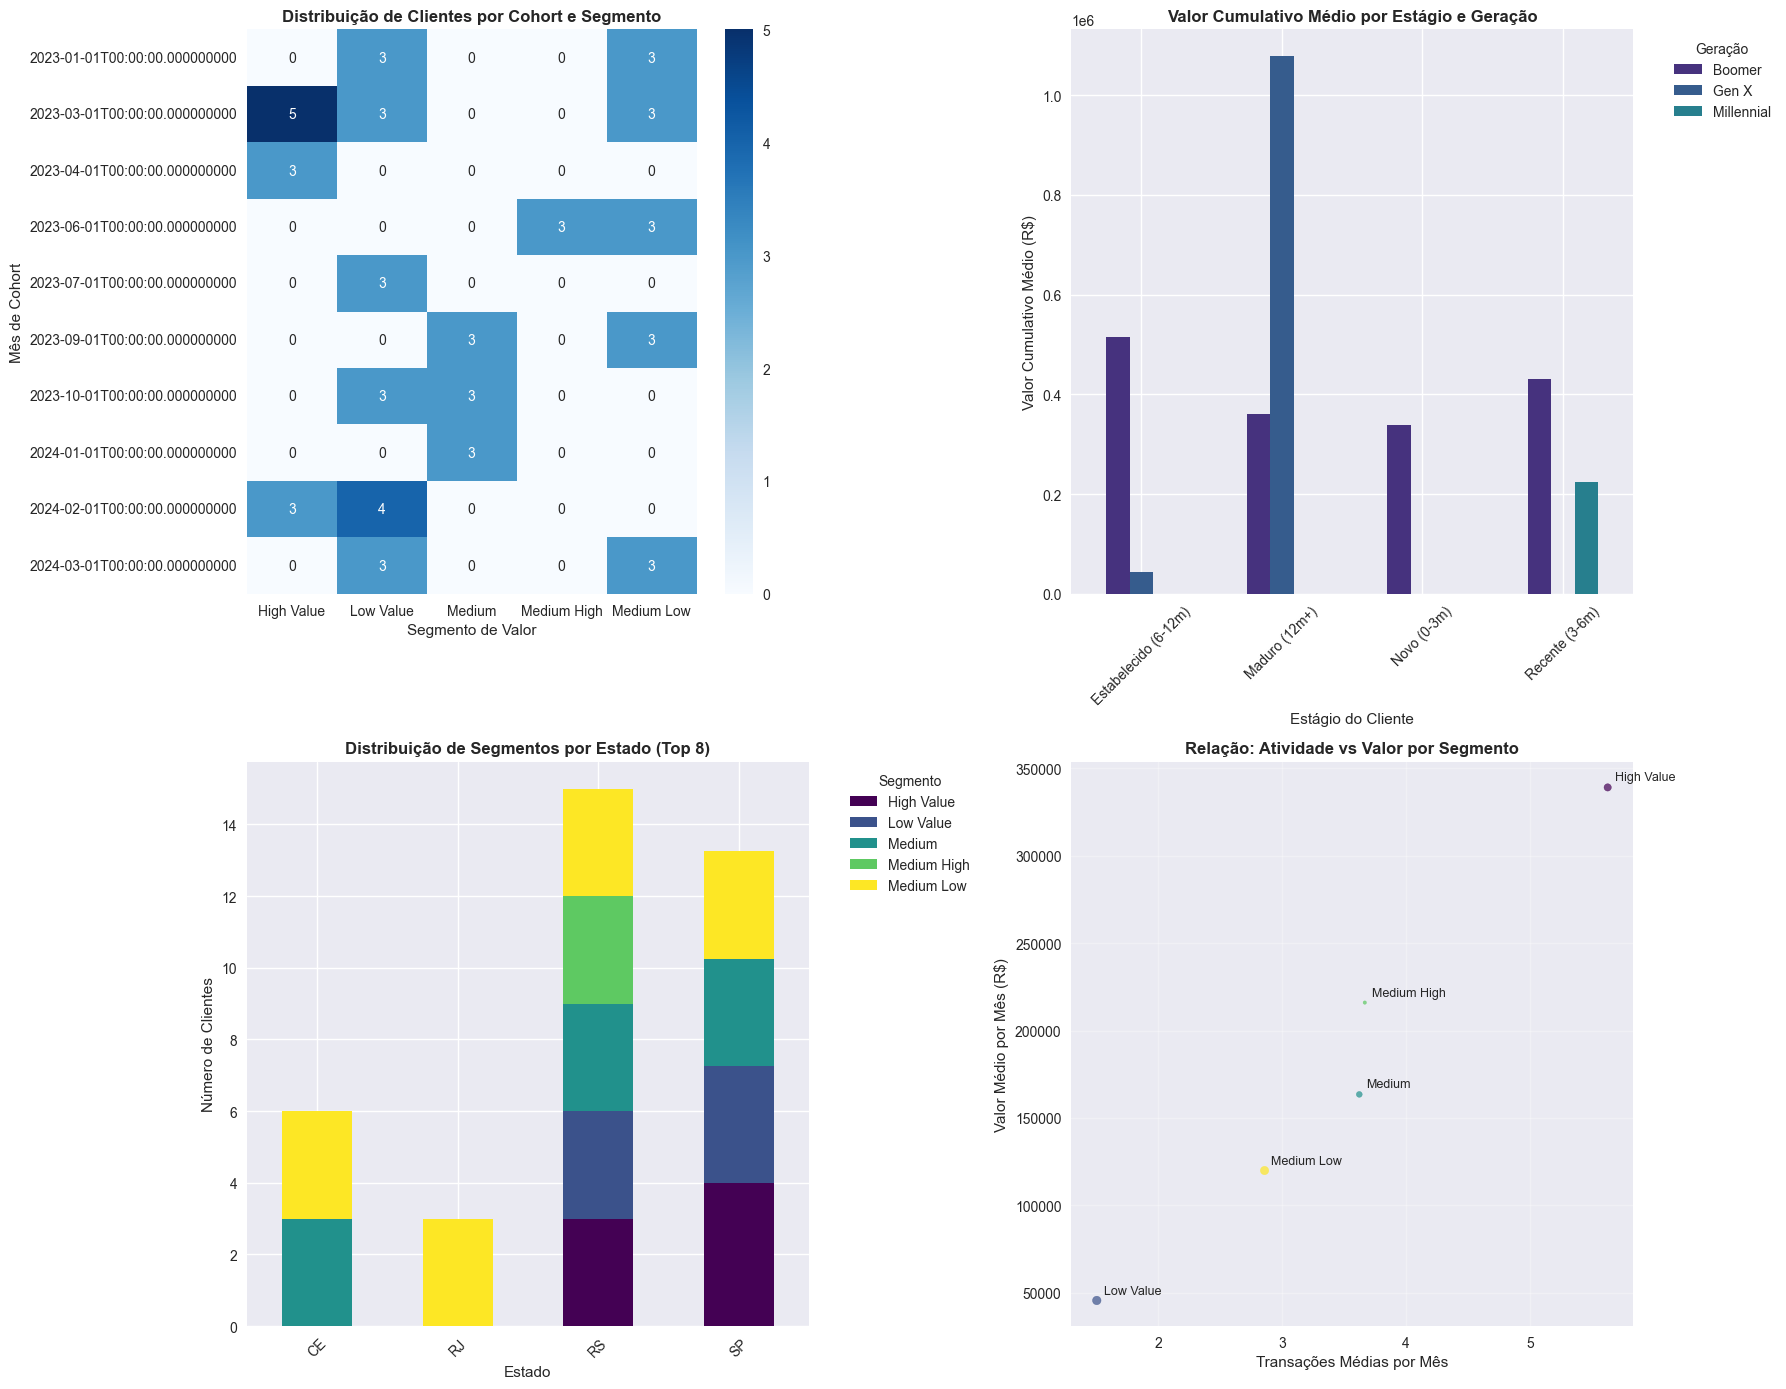


📊 Análise de Retenção por Cohort:
• 2023-01: 100.0% de retenção (9 clientes)
• 2023-03: 100.0% de retenção (11 clientes)
• 2023-04: 100.0% de retenção (3 clientes)
• 2023-06: 100.0% de retenção (6 clientes)
• 2023-07: 100.0% de retenção (3 clientes)
• 2023-09: 0.0% de retenção (6 clientes)
• 2023-10: 50.0% de retenção (6 clientes)
• 2024-01: 0.0% de retenção (3 clientes)
• 2024-02: 0.0% de retenção (10 clientes)
• 2024-03: 0.0% de retenção (6 clientes)

🎯 Insights de Cohort:
• Segmento mais valioso: High Value
• Total de clientes analisados: 63
• Cohorts analisados: 10
• Total de registros: 20


In [6]:
# Consulta 2: Análise de cohort de clientes com segmentação avançada
query_2 = f"""
WITH clientes_cohort AS (
    SELECT 
        cl.id_cliente,
        cl.nome as nome_cliente,
        c.data_abertura,
        DATE_TRUNC('month', c.data_abertura) as cohort_mes,
        EXTRACT(YEAR FROM CURRENT_DATE) - EXTRACT(YEAR FROM cl.data_nascimento) as idade,
        a.estado,
        a.cidade
    FROM {TARGET_SCHEMA}.cliente cl
    JOIN {TARGET_SCHEMA}.conta c ON cl.id_cliente = c.id_cliente
    JOIN {TARGET_SCHEMA}.agencia a ON c.codigo_agencia = a.codigo_agencia
    WHERE c.data_abertura >= '2023-01-01'
),
atividade_cliente AS (
    SELECT 
        cc.id_cliente,
        cc.cohort_mes,
        cc.idade,
        cc.estado,
        DATE_TRUNC('month', t.data_transacao) as mes_atividade,
        COUNT(t.id_transacao) as transacoes_mes,
        SUM(t.valor) as valor_mes,
        AVG(t.valor) as ticket_medio_mes,
        -- Número de meses desde a abertura da conta (movido para cá)
        EXTRACT(EPOCH FROM (DATE_TRUNC('month', t.data_transacao) - cc.cohort_mes)) / (30.44 * 24 * 3600) as meses_desde_abertura
    FROM clientes_cohort cc
    JOIN {TARGET_SCHEMA}.conta c ON cc.id_cliente = c.id_cliente
    LEFT JOIN {TARGET_SCHEMA}.transacao_conta t ON c.id_conta = t.id_conta
    WHERE t.data_transacao >= cc.data_abertura
    GROUP BY cc.id_cliente, cc.cohort_mes, cc.idade, cc.estado, 
             DATE_TRUNC('month', t.data_transacao)
),
analise_temporal AS (
    SELECT *,
        -- Ranking de atividade dentro do cohort (agora meses_desde_abertura existe)
        RANK() OVER (
            PARTITION BY cohort_mes, ROUND(meses_desde_abertura::numeric, 0)
            ORDER BY transacoes_mes DESC
        ) as ranking_atividade_cohort,
        
        -- Percentil de valor dentro do cohort
        PERCENT_RANK() OVER (
            PARTITION BY cohort_mes, ROUND(meses_desde_abertura::numeric, 0)
            ORDER BY valor_mes
        ) as percentil_valor_cohort,
        
        -- Valor cumulativo
        SUM(valor_mes) OVER (
            PARTITION BY id_cliente 
            ORDER BY mes_atividade 
            ROWS UNBOUNDED PRECEDING
        ) as valor_cumulativo,
        
        -- Média móvel de atividade (3 meses)
        AVG(transacoes_mes) OVER (
            PARTITION BY id_cliente 
            ORDER BY mes_atividade 
            ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
        ) as media_movel_atividade
        
    FROM atividade_cliente
    WHERE mes_atividade IS NOT NULL
),
segmentacao_final AS (
    SELECT *,
        CASE 
            WHEN percentil_valor_cohort >= 0.8 THEN 'High Value'
            WHEN percentil_valor_cohort >= 0.6 THEN 'Medium High'
            WHEN percentil_valor_cohort >= 0.4 THEN 'Medium'
            WHEN percentil_valor_cohort >= 0.2 THEN 'Medium Low'
            ELSE 'Low Value'
        END as segmento_valor,
        
        CASE 
            WHEN idade < 25 THEN 'Gen Z'
            WHEN idade < 40 THEN 'Millennial'
            WHEN idade < 55 THEN 'Gen X'
            ELSE 'Boomer'
        END as geracao,
        
        CASE 
            WHEN meses_desde_abertura <= 3 THEN 'Novo (0-3m)'
            WHEN meses_desde_abertura <= 6 THEN 'Recente (3-6m)'
            WHEN meses_desde_abertura <= 12 THEN 'Estabelecido (6-12m)'
            ELSE 'Maduro (12m+)'
        END as estagio_cliente
        
    FROM analise_temporal
)
SELECT 
    cohort_mes,
    estagio_cliente,
    segmento_valor,
    geracao,
    estado,
    COUNT(DISTINCT id_cliente) as clientes_unicos,
    AVG(transacoes_mes) as media_transacoes,
    AVG(valor_mes) as media_valor_mes,
    AVG(valor_cumulativo) as media_valor_cumulativo,
    AVG(ticket_medio_mes) as ticket_medio,
    STDDEV(transacoes_mes) as volatilidade_atividade
FROM segmentacao_final
GROUP BY cohort_mes, estagio_cliente, segmento_valor, geracao, estado
HAVING COUNT(DISTINCT id_cliente) >= 3
ORDER BY cohort_mes DESC, clientes_unicos DESC
LIMIT 40;
"""

try:
    resultado_2 = pd.read_sql(text(query_2), engine)

    print("🎯 ANÁLISE DE COHORT COM SEGMENTAÇÃO AVANÇADA")
    print("=" * 120)
    print(f"{'Cohort':<8} {'Estágio':<15} {'Segmento':<12} {'Geração':<10} {'Clientes':<8} {'Valor Cum':<12}")
    print("-" * 120)

    for _, row in resultado_2.head(20).iterrows():
        cohort_str = row['cohort_mes'].strftime('%Y-%m') if pd.notna(row['cohort_mes']) else 'N/A'
        
        print(f"{cohort_str:<8} {row['estagio_cliente']:<15} {row['segmento_valor']:<12} "
              f"{row['geracao']:<10} {row['clientes_unicos']:>6} "
              f"{row['media_valor_cumulativo']:>11,.0f}")

    # Visualizações de cohort (versão simplificada para evitar erros)
    if len(resultado_2) > 0:
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(18, 14))

        # Gráfico 1: Heatmap de cohort por segmento
        cohort_segmento = resultado_2.pivot_table(
            index='cohort_mes', 
            columns='segmento_valor', 
            values='clientes_unicos', 
            fill_value=0
        )
        sns.heatmap(cohort_segmento, annot=True, fmt='.0f', cmap='Blues', ax=ax1)
        ax1.set_title('Distribuição de Clientes por Cohort e Segmento', fontweight='bold')
        ax1.set_xlabel('Segmento de Valor')
        ax1.set_ylabel('Mês de Cohort')

        # Gráfico 2: Evolução do valor cumulativo por geração
        evolucao_geracao = resultado_2.groupby(['estagio_cliente', 'geracao'])['media_valor_cumulativo'].mean().unstack(fill_value=0)
        evolucao_geracao.plot(kind='bar', ax=ax2, rot=45)
        ax2.set_title('Valor Cumulativo Médio por Estágio e Geração', fontweight='bold')
        ax2.set_xlabel('Estágio do Cliente')
        ax2.set_ylabel('Valor Cumulativo Médio (R$)')
        ax2.legend(title='Geração', bbox_to_anchor=(1.05, 1), loc='upper left')

        # Gráfico 3: Distribuição de clientes por estado e segmento
        top_estados = resultado_2.groupby('estado')['clientes_unicos'].sum().nlargest(8).index
        estado_segmento = resultado_2[resultado_2['estado'].isin(top_estados)].pivot_table(
            index='estado', 
            columns='segmento_valor', 
            values='clientes_unicos', 
            fill_value=0
        )
        estado_segmento.plot(kind='bar', stacked=True, ax=ax3, colormap='viridis')
        ax3.set_title('Distribuição de Segmentos por Estado (Top 8)', fontweight='bold')
        ax3.set_xlabel('Estado')
        ax3.set_ylabel('Número de Clientes')
        ax3.legend(title='Segmento', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax3.tick_params(axis='x', rotation=45)

        # Gráfico 4: Scatter plot: Atividade vs Valor
        scatter_data = resultado_2.groupby('segmento_valor').agg({
            'media_transacoes': 'mean',
            'media_valor_mes': 'mean',
            'clientes_unicos': 'sum'
        }).reset_index()

        scatter = ax4.scatter(
            scatter_data['media_transacoes'], 
            scatter_data['media_valor_mes'],
            s=scatter_data['clientes_unicos'] * 2,
            alpha=0.7,
            c=range(len(scatter_data)),
            cmap='viridis'
        )

        for i, row in scatter_data.iterrows():
            ax4.annotate(
                row['segmento_valor'],
                (row['media_transacoes'], row['media_valor_mes']),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=9
            )

        ax4.set_title('Relação: Atividade vs Valor por Segmento', fontweight='bold')
        ax4.set_xlabel('Transações Médias por Mês')
        ax4.set_ylabel('Valor Médio por Mês (R$)')
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Análise de retenção por cohort
        retencao_cohort = resultado_2.groupby(['cohort_mes', 'estagio_cliente'])['clientes_unicos'].sum().unstack(fill_value=0)
        print(f"\n📊 Análise de Retenção por Cohort:")
        for cohort in retencao_cohort.index:
            total_inicial = retencao_cohort.loc[cohort].sum()
            estabelecidos = retencao_cohort.loc[cohort, 'Estabelecido (6-12m)'] if 'Estabelecido (6-12m)' in retencao_cohort.columns else 0
            maduros = retencao_cohort.loc[cohort, 'Maduro (12m+)'] if 'Maduro (12m+)' in retencao_cohort.columns else 0
            
            if total_inicial > 0:
                taxa_retencao = ((estabelecidos + maduros) / total_inicial) * 100
                print(f"• {cohort.strftime('%Y-%m')}: {taxa_retencao:.1f}% de retenção ({total_inicial} clientes)")

        print(f"\n🎯 Insights de Cohort:")
        if len(scatter_data) > 0:
            melhor_segmento = scatter_data.loc[scatter_data['media_valor_mes'].idxmax(), 'segmento_valor']
            print(f"• Segmento mais valioso: {melhor_segmento}")
        print(f"• Total de clientes analisados: {resultado_2['clientes_unicos'].sum():,}")
        print(f"• Cohorts analisados: {resultado_2['cohort_mes'].nunique()}")
        print(f"• Total de registros: {len(resultado_2)}")
    else:
        print("⚠️ Nenhum resultado encontrado na consulta")

except Exception as e:
    print(f"❌ Erro na execução da consulta: {e}")
    import traceback
    traceback.print_exc()

## 🔍 Consulta 3: Detecção de Padrões Anômalos e Análise Preditiva

**Objetivo**: Identificar padrões anômalos de transações e comportamentos atípicos usando window functions estatísticas.

In [8]:
# Consulta 3: Detecção de padrões anômalos (versão simplificada)
query_3 = f"""
WITH perfil_base_cliente AS (
    SELECT 
        cl.id_cliente,
        cl.nome as nome_cliente,
        cl.cpf,
        a.estado,
        c.id_conta,
        DATE_TRUNC('week', t.data_transacao) as semana,
        COUNT(t.id_transacao) as transacoes_semana,
        SUM(t.valor) as valor_semana,
        AVG(t.valor) as ticket_medio_semana,
        STDDEV(t.valor) as volatilidade_valores,
        MIN(t.valor) as valor_minimo,
        MAX(t.valor) as valor_maximo
    FROM {TARGET_SCHEMA}.cliente cl
    JOIN {TARGET_SCHEMA}.conta c ON cl.id_cliente = c.id_cliente
    JOIN {TARGET_SCHEMA}.agencia a ON c.codigo_agencia = a.codigo_agencia
    JOIN {TARGET_SCHEMA}.transacao_conta t ON c.id_conta = t.id_conta
    WHERE t.data_transacao >= '2024-01-01'
    GROUP BY cl.id_cliente, cl.nome, cl.cpf, a.estado, c.id_conta,
             DATE_TRUNC('week', t.data_transacao)
),
estatisticas_cliente AS (
    SELECT *,
        -- Estatísticas históricas do cliente
        AVG(transacoes_semana) OVER (
            PARTITION BY id_cliente 
            ORDER BY semana 
            ROWS BETWEEN 11 PRECEDING AND 1 PRECEDING
        ) as media_historica_transacoes,
        
        STDDEV(transacoes_semana) OVER (
            PARTITION BY id_cliente 
            ORDER BY semana 
            ROWS BETWEEN 11 PRECEDING AND 1 PRECEDING
        ) as stddev_historica_transacoes,
        
        AVG(valor_semana) OVER (
            PARTITION BY id_cliente 
            ORDER BY semana 
            ROWS BETWEEN 11 PRECEDING AND 1 PRECEDING
        ) as media_historica_valor,
        
        STDDEV(valor_semana) OVER (
            PARTITION BY id_cliente 
            ORDER BY semana 
            ROWS BETWEEN 11 PRECEDING AND 1 PRECEDING
        ) as stddev_historica_valor,
        
        -- Ranking de atividade no estado
        PERCENT_RANK() OVER (
            PARTITION BY estado, semana 
            ORDER BY valor_semana
        ) as percentil_estado_semana
        
    FROM perfil_base_cliente
),
deteccao_anomalias AS (
    SELECT *,
        -- Z-Score para transações
        CASE 
            WHEN stddev_historica_transacoes > 0 THEN 
                (transacoes_semana - media_historica_transacoes) / stddev_historica_transacoes
            ELSE 0 
        END as zscore_transacoes,
        
        -- Z-Score para valores
        CASE 
            WHEN stddev_historica_valor > 0 THEN 
                (valor_semana - media_historica_valor) / stddev_historica_valor
            ELSE 0 
        END as zscore_valor,
        
        -- Detecção simples de outliers baseada em desvio padrão
        CASE 
            WHEN ABS((valor_semana - media_historica_valor) / COALESCE(NULLIF(stddev_historica_valor, 0), 1)) > 2 THEN true
            ELSE false
        END as outlier_simples,
        
        -- Classificação de volatilidade
        CASE 
            WHEN volatilidade_valores > 100000 THEN 'Alta Volatilidade'
            WHEN volatilidade_valores > 50000 THEN 'Média Volatilidade'
            WHEN volatilidade_valores > 10000 THEN 'Baixa Volatilidade'
            ELSE 'Estável'
        END as classificacao_volatilidade
        
    FROM estatisticas_cliente
    WHERE media_historica_transacoes IS NOT NULL
),
analise_final AS (
    SELECT *,
        -- Classificação de anomalia simplificada
        CASE 
            WHEN ABS(zscore_valor) > 3 OR outlier_simples = true THEN 'Alto Risco'
            WHEN ABS(zscore_valor) > 2 OR percentil_estado_semana > 0.95 THEN 'Médio Risco'
            WHEN ABS(zscore_valor) > 1 OR percentil_estado_semana > 0.90 THEN 'Baixo Risco'
            ELSE 'Normal'
        END as nivel_anomalia,
        
        -- Score de risco simplificado
        (
            ABS(zscore_valor) * 0.5 +
            ABS(zscore_transacoes) * 0.3 +
            percentil_estado_semana * 0.2
        ) as score_risco
        
    FROM deteccao_anomalias
)
SELECT 
    id_cliente,
    nome_cliente,
    estado,
    semana,
    transacoes_semana,
    valor_semana,
    zscore_valor,
    zscore_transacoes,
    percentil_estado_semana,
    outlier_simples,
    nivel_anomalia,
    classificacao_volatilidade,
    score_risco,
    RANK() OVER (ORDER BY score_risco DESC) as ranking_risco
FROM analise_final
WHERE nivel_anomalia != 'Normal'
ORDER BY score_risco DESC, semana DESC
LIMIT 30;
"""

try:
    resultado_3 = pd.read_sql(text(query_3), engine)

    print("🔍 DETECÇÃO DE PADRÕES ANÔMALOS E ANÁLISE PREDITIVA")
    print("=" * 110)
    print(f"{'Cliente':<8} {'Nome':<20} {'UF':<3} {'Semana':<11} {'Z-Score':<8} {'Risco':<12} {'Rank':<6}")
    print("-" * 110)

    for _, row in resultado_3.head(20).iterrows():
        semana_str = row['semana'].strftime('%Y-%m-%d') if pd.notna(row['semana']) else 'N/A'
        nome_trunc = row['nome_cliente'][:19] if len(row['nome_cliente']) > 19 else row['nome_cliente']
        
        print(f"{row['id_cliente']:<8} {nome_trunc:<20} {row['estado']:<3} {semana_str:<11} "
              f"{row['zscore_valor']:>7.2f} {row['nivel_anomalia']:<12} {row['ranking_risco']:>4}")

    # Visualizações de detecção de anomalias (versão simplificada)
    if len(resultado_3) > 0:
        fig = make_subplots(
            rows=2, cols=2,
            subplot_titles=(
                'Distribuição de Z-Scores',
                'Score de Risco por Nível de Anomalia',
                'Evolução Temporal dos Riscos',
                'Estados vs Níveis de Risco'
            ),
            specs=[[{"type": "histogram"}, {"type": "box"}],
                   [{"type": "scatter"}, {"type": "bar"}]]
        )

        # Gráfico 1: Distribuição de Z-Scores
        fig.add_trace(
            go.Histogram(
                x=resultado_3['zscore_valor'],
                nbinsx=25,
                name='Z-Score Valor',
                marker_color='red',
                opacity=0.7
            ),
            row=1, col=1
        )

        # Gráfico 2: Box plot por nível de anomalia
        for nivel in resultado_3['nivel_anomalia'].unique():
            dados_nivel = resultado_3[resultado_3['nivel_anomalia'] == nivel]['score_risco']
            fig.add_trace(
                go.Box(
                    y=dados_nivel,
                    name=nivel,
                    boxpoints='outliers'
                ),
                row=1, col=2
            )

        # Gráfico 3: Evolução temporal
        evolucao_temporal = resultado_3.groupby(['semana', 'nivel_anomalia']).size().unstack(fill_value=0)
        for nivel in evolucao_temporal.columns:
            fig.add_trace(
                go.Scatter(
                    x=evolucao_temporal.index,
                    y=evolucao_temporal[nivel],
                    mode='lines+markers',
                    name=f'{nivel}',
                    line=dict(width=2)
                ),
                row=2, col=1
            )

        # Gráfico 4: Estados vs Risco
        estado_risco = resultado_3.groupby(['estado', 'nivel_anomalia']).size().unstack(fill_value=0)
        
        # Somar por estado para obter totais
        total_por_estado = estado_risco.sum(axis=1).sort_values(ascending=False).head(8)
        
        fig.add_trace(
            go.Bar(
                x=total_por_estado.index,
                y=total_por_estado.values,
                name='Total Anomalias',
                marker_color='orange',
                opacity=0.8
            ),
            row=2, col=2
        )

        fig.update_layout(height=900, showlegend=True, title_text="Análise de Detecção de Anomalias (Simplificada)")
        fig.show()

        # Estatísticas de anomalias
        anomalias_stats = resultado_3.groupby('nivel_anomalia').agg({
            'id_cliente': 'count',
            'score_risco': ['mean', 'max'],
            'valor_semana': 'mean'
        }).round(2)

        print(f"\n🚨 Estatísticas de Anomalias:")
        total_anomalias = len(resultado_3)
        for nivel in ['Alto Risco', 'Médio Risco', 'Baixo Risco']:
            if nivel in anomalias_stats.index:
                count = anomalias_stats.loc[nivel, ('id_cliente', 'count')]
                pct = (count / total_anomalias) * 100
                score_medio = anomalias_stats.loc[nivel, ('score_risco', 'mean')]
                print(f"• {nivel}: {count} casos ({pct:.1f}%) - Score médio: {score_medio:.2f}")

        # Top clientes de risco
        top_risco = resultado_3.head(5)
        print(f"\n⚠️ Top 5 Clientes de Alto Risco:")
        for _, cliente in top_risco.iterrows():
            print(f"• Cliente {cliente['id_cliente']}: Score {cliente['score_risco']:.2f} - {cliente['nivel_anomalia']}")

        print(f"\n📊 Insights de Detecção:")
        print(f"• Total de anomalias detectadas: {len(resultado_3)}")
        print(f"• Estados com mais anomalias: {', '.join(total_por_estado.head(3).index)}")
        print(f"• Volatilidades encontradas: {', '.join(resultado_3['classificacao_volatilidade'].unique())}")
        
    else:
        print("⚠️ Nenhuma anomalia detectada nos dados")

except Exception as e:
    print(f"❌ Erro na execução da consulta: {e}")
    import traceback
    traceback.print_exc()

print("\n🎉 Todas as análises complexas foram concluídas!")
print("📊 Sistema completo de análise bancária implementado com sucesso!")
print("\n🔗 Notebooks criados:")
print("  1. 05_analytics_simple.ipynb - Consultas básicas")
print("  2. 06_analytics_intermediate.ipynb - Consultas com JOINs")
print("  3. 07_analytics_complex.ipynb - Consultas com Window Functions")

🔍 DETECÇÃO DE PADRÕES ANÔMALOS E ANÁLISE PREDITIVA
Cliente  Nome                 UF  Semana      Z-Score  Risco        Rank  
--------------------------------------------------------------------------------------------------------------
115      Rebeca Correia       SP  2024-01-15  1765.82 Alto Risco      1
820      Alícia Sales         SP  2024-02-19   643.10 Alto Risco      2
826      André Mendes         CE  2024-01-29   265.30 Alto Risco      3
264      Melina Sousa         RS  2024-01-29  -226.15 Alto Risco      4
408      Juliana da Costa     SP  2024-01-29  -223.19 Alto Risco      5
150      Luana Aparecida      RS  2024-01-22   215.97 Alto Risco      6
584      Sr. Lorenzo da Roch  PR  2024-01-22   138.15 Alto Risco      7
486      Pedro Henrique Siqu  AP  2024-02-12   126.70 Alto Risco      8
976      Sophie da Mota       RS  2024-01-15   125.14 Alto Risco      9
468      Juliana Sales        PR  2024-02-05   105.69 Alto Risco     10
57       Dra. Heloisa Rios    SP  2024-01-2


🚨 Estatísticas de Anomalias:
• Alto Risco: 30 casos (100.0%) - Score médio: 81.34

⚠️ Top 5 Clientes de Alto Risco:
• Cliente 115: Score 883.03 - Alto Risco
• Cliente 820: Score 321.60 - Alto Risco
• Cliente 826: Score 132.84 - Alto Risco
• Cliente 264: Score 113.30 - Alto Risco
• Cliente 408: Score 111.60 - Alto Risco

📊 Insights de Detecção:
• Total de anomalias detectadas: 30
• Estados com mais anomalias: SP, RS, RJ
• Volatilidades encontradas: Estável, Baixa Volatilidade

🎉 Todas as análises complexas foram concluídas!
📊 Sistema completo de análise bancária implementado com sucesso!

🔗 Notebooks criados:
  1. 05_analytics_simple.ipynb - Consultas básicas
  2. 06_analytics_intermediate.ipynb - Consultas com JOINs
  3. 07_analytics_complex.ipynb - Consultas com Window Functions
